# 2.5: Technical Indicators & Signal Design

## 🎯 Objective
This notebook implements a technical analysis system that:
1. **Computes technical indicators** for each stock (SMA, EMA, RSI, MACD, ATR)
2. **Generates entry/exit signals** based on indicator combinations
3. **Derives signal-based weights** using signal strength
4. **Creates signal-weighted portfolio** with normalized weights across assets

## 📊 Technical Indicators Overview

### Moving Averages
- **SMA (Simple Moving Average)**: Arithmetic mean of prices over N periods
- **EMA (Exponential Moving Average)**: Weighted average giving more importance to recent prices

### Momentum Indicators  
- **RSI (Relative Strength Index)**: Measures overbought/oversold conditions (0-100 scale)
- **MACD (Moving Average Convergence Divergence)**: Trend-following momentum indicator

### Volatility Indicators
- **ATR (Average True Range)**: Measures market volatility

## 🔄 Signal Generation Strategy

**Long Signal**: `(RSI < 30) & (MACD > MACD_signal)`
- RSI below 30 indicates oversold condition (potential upward reversal)
- MACD above signal line indicates bullish momentum

**Short Signal**: `(RSI > 70) & (MACD < MACD_signal)`  
- RSI above 70 indicates overbought condition (potential downward reversal)
- MACD below signal line indicates bearish momentum

## ⚖️ Weight Calculation
`adjusted_weight = base_weight × signal_strength`

Where signal strength is derived from indicator values and combined signals.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Libraries imported successfully!")
print("🛠️ Technical Indicators & Signal Design System Ready!")

# Configuration parameters
TECHNICAL_CONFIG = {
    'sma_period': 20,        # Simple Moving Average period
    'ema_period': 12,        # Exponential Moving Average period
    'rsi_period': 14,        # RSI calculation period
    'macd_fast': 12,         # MACD fast EMA period
    'macd_slow': 26,         # MACD slow EMA period
    'macd_signal': 9,        # MACD signal line period
    'atr_period': 14,        # Average True Range period
    'rsi_oversold': 30,      # RSI oversold threshold
    'rsi_overbought': 70,    # RSI overbought threshold
    'base_weight': 0.1       # Base weight for signal calculation
}

print(f"⚙️ Technical analysis parameters configured:")
for param, value in TECHNICAL_CONFIG.items():
    print(f"  {param}: {value}")

print(f"\n🎯 Signal Generation Rules:")
print(f"  • Long: RSI < {TECHNICAL_CONFIG['rsi_oversold']} " +
      "AND MACD > MACD_signal")
print(f"  • Short: RSI > {TECHNICAL_CONFIG['rsi_overbought']} " +
      "AND MACD < MACD_signal")
print(f"  • Weight Adjustment: base_weight × signal_strength")

📚 Libraries imported successfully!
🛠️ Technical Indicators & Signal Design System Ready!
⚙️ Technical analysis parameters configured:
  sma_period: 20
  ema_period: 12
  rsi_period: 14
  macd_fast: 12
  macd_slow: 26
  macd_signal: 9
  atr_period: 14
  rsi_oversold: 30
  rsi_overbought: 70
  base_weight: 0.1

🎯 Signal Generation Rules:
  • Long: RSI < 30 AND MACD > MACD_signal
  • Short: RSI > 70 AND MACD < MACD_signal
  • Weight Adjustment: base_weight × signal_strength


## Step 1: Data Loading & Preparation

Load the preprocessed S&P 500 price data from Part 1 and prepare it for technical analysis.

In [ ]:
# Load preprocessed S&P 500 price data
print("📊 Loading S&P 500 price data...")

# Try to load data from Part 1
prices_df = pd.read_csv(
    '../Part 1: Data Acquisition & Preprocessing/sp500_prices_5yr.csv', 
    index_col=0, parse_dates=True)
print(f"✅ Successfully loaded price data from Part 1")
print(f"📈 Price data shape: {prices_df.shape}")
print(f"📅 Date range: {prices_df.index.min().strftime('%Y-%m-%d')} " +
      f"to {prices_df.index.max().strftime('%Y-%m-%d')}")

# Display basic information about the data
print(f"\n📋 Dataset Overview:")
print(f"  • Number of assets: {len(prices_df.columns)}")
print(f"  • Number of trading days: {len(prices_df)}")
print(f"  • Data frequency: Daily")
print(f"  • Missing values: {prices_df.isnull().sum().sum()}")

# Display sample data
print(f"\n📊 Sample Price Data (first 5 rows, first 5 columns):")
print(prices_df.iloc[:5, :5])

print(f"\n📈 Price Statistics (first 5 assets):")
print(prices_df.iloc[:, :5].describe())

# Store tickers list for later use
tickers = list(prices_df.columns)
print(f"\n🎯 Assets for technical analysis: {len(tickers)} tickers")
print(f"Sample tickers: {tickers[:10]}" +
      f"{'...' if len(tickers) > 10 else ''}")

📊 Loading S&P 500 price data...
✅ Successfully loaded price data from Part 1
📈 Price data shape: (1254, 100)
📅 Date range: 2020-08-07 to 2025-08-05

📋 Dataset Overview:
  • Number of assets: 100
  • Number of trading days: 1254
  • Data frequency: Daily
  • Missing values: 0

📊 Sample Price Data (first 5 rows, first 5 columns):
                 AAPL      GOOG     GOOGL       AMZN      AVGO
2020-08-07 108.203781 74.282951 74.471870 158.373001 28.915098
2020-08-10 109.776497 74.362968 74.394821 157.408005 29.041964
2020-08-11 106.511749 73.578644 73.585678 154.033493 28.746536
2020-08-12 110.051590 74.885872 74.912720 158.112000 29.599102
2020-08-13 111.999237 75.473869 75.380417 158.050995 29.224718

📈 Price Statistics (first 5 assets):
             AAPL        GOOG       GOOGL        AMZN        AVGO
count 1254.000000 1254.000000 1254.000000 1254.000000 1254.000000
mean   168.424444  131.988279  130.979755  157.791528   93.916028
std     36.174476   31.651996   31.293769   35.356328   

## Step 2: Technical Indicators Calculation

Implement and calculate technical indicators for each stock:

- **SMA (Simple Moving Average)**: Trend identification

- **EMA (Exponential Moving Average)**: Trend with recent price emphasis 

- **RSI (Relative Strength Index)**: Momentum and overbought/oversold conditions

- **MACD (Moving Average Convergence Divergence)**: Trend and momentum

- **ATR (Average True Range)**: Volatility measurement

In [ ]:
# Technical Indicators Calculation Functions
print("🔧 Implementing technical indicators calculation functions...")

def calculate_sma(prices, period):
    """
    Calculate Simple Moving Average
    """
    return prices.rolling(window=period).mean()

def calculate_ema(prices, period):
    """
    Calculate Exponential Moving Average
    """
    return prices.ewm(span=period, adjust=False).mean()

def calculate_rsi(prices, period=14):
    """
    Calculate Relative Strength Index
    """
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """
    Calculate MACD and Signal Line
    """
    ema_fast = calculate_ema(prices, fast)
    ema_slow = calculate_ema(prices, slow)
    
    macd_line = ema_fast - ema_slow
    macd_signal = calculate_ema(macd_line, signal)
    macd_histogram = macd_line - macd_signal
    
    return macd_line, macd_signal, macd_histogram

def calculate_atr(high, low, close, period=14):
    """
    Calculate Average True Range
    """
    # For price data, we'll use high=close, low=close 
    # (since we only have close prices)
    # This is a simplified ATR calculation
    tr = pd.DataFrame({
        'hl': close.diff().abs(),  # High-Low equivalent using price changes
        'hc': close.diff().abs(),  # High-Close equivalent  
        'lc': close.diff().abs()   # Low-Close equivalent
    }).max(axis=1)
    
    atr = tr.rolling(window=period).mean()
    return atr

def calculate_all_indicators(prices_df, config):
    """
    Calculate all technical indicators for all stocks
    """
    print(f"📊 Calculating technical indicators for " +
          f"{len(prices_df.columns)} stocks...")
    
    indicators = {}
    
    for ticker in prices_df.columns:
        print(f"  Processing {ticker}...", end=" ")
        
        prices = prices_df[ticker].dropna()
        
        # Calculate all indicators
        sma = calculate_sma(prices, config['sma_period'])
        ema = calculate_ema(prices, config['ema_period'])
        rsi = calculate_rsi(prices, config['rsi_period'])
        macd, macd_signal, macd_hist = calculate_macd(
            prices, config['macd_fast'], 
            config['macd_slow'], config['macd_signal']
        )
        # Simplified for close prices
        atr = calculate_atr(prices, prices, prices, config['atr_period'])
        
        # Store in dictionary
        indicators[ticker] = {
            'prices': prices,
            'sma': sma,
            'ema': ema,
            'rsi': rsi,
            'macd': macd,
            'macd_signal': macd_signal,
            'macd_histogram': macd_hist,
            'atr': atr
        }
        
        print("✅")
    
    print(f"🎯 Technical indicators calculated for all {len(indicators)} assets!")
    return indicators

# Calculate indicators for all stocks
technical_indicators = calculate_all_indicators(prices_df, TECHNICAL_CONFIG)

print(f"\n📋 Indicator Summary:")
sample_ticker = list(technical_indicators.keys())[0]
sample_data = technical_indicators[sample_ticker]

for indicator, data in sample_data.items():
    if isinstance(data, pd.Series):
        valid_count = data.dropna().shape[0]
        print(f"  {indicator:15}: {valid_count:4d} valid values")

print(f"\n✅ All technical indicators calculated successfully!")

🔧 Implementing technical indicators calculation functions...
📊 Calculating technical indicators for 100 stocks...
  Processing AAPL... ✅
  Processing GOOG... ✅
  Processing GOOGL... ✅
  Processing AMZN... ✅
  Processing AVGO... ✅
  Processing BRK-B... ✅
  Processing COST... ✅
  Processing ABBV... ✅
  Processing BAC... ✅
  Processing CVX... ✅
  Processing KO... ✅
  Processing CSCO... ✅
  Processing AMD... ✅
  Processing ABT... ✅
  Processing BX... ✅
  Processing AXP... ✅
  Processing CAT... ✅
  Processing T... ✅
  Processing BKNG... ✅
  Processing SCHW... ✅
  Processing ANET... ✅
  Processing BLK... ✅
  Processing BA... ✅
  Processing C... ✅
  Processing ACN... ✅
  Processing AMGN... ✅
  Processing BSX... ✅
  Processing ADBE... ✅
  Processing AMAT... ✅
  Processing DHR... ✅
  Processing DE... ✅
  Processing COF... ✅
  Processing APH... ✅
  Processing ADP... ✅
  Processing CMCSA... ✅
  Processing COP... ✅
  Processing CRWD... ✅
  Processing ADI... ✅
  Processing CB... ✅
  Processing MO..

## Step 3: Signal Generation

Generate entry/exit signals based on technical indicators:

### Signal Rules:
- **Long Signal**: `(RSI < 30) & (MACD > MACD_signal)`
  - RSI < 30: Oversold condition (potential reversal up)
  - MACD > Signal: Bullish momentum confirmation
  
- **Short Signal**: `(RSI > 70) & (MACD < MACD_signal)`  
  - RSI > 70: Overbought condition (potential reversal down)
  - MACD < Signal: Bearish momentum confirmation

### Signal Values:
- **+1**: Long signal (Buy)
- **-1**: Short signal (Sell)  
- **0**: Neutral (Hold)

In [32]:
# Signal Generation Implementation
print("🚦 Generating entry/exit signals based on technical indicators...")

def generate_signals(indicators, config):
    """Generate buy/sell/hold signals for all stocks"""
    signals = {}
    signal_summary = {'long_signals': 0, 'short_signals': 0, 'total_periods': 0}
    
    rsi_oversold = config['rsi_oversold']
    rsi_overbought = config['rsi_overbought']
    
    for ticker, data in indicators.items():
        # Extract required indicators
        rsi = data['rsi']
        macd = data['macd']
        macd_signal = data['macd_signal']
        
        # Generate long signals: RSI < 30 AND MACD > MACD_signal
        long_condition = (rsi < rsi_oversold) & (macd > macd_signal)
        
        # Generate short signals: RSI > 70 AND MACD < MACD_signal  
        short_condition = (rsi > rsi_overbought) & (macd < macd_signal)
        
        # Create signal series: +1 for long, -1 for short, 0 for neutral
        signal = pd.Series(0, index=rsi.index, dtype=int)
        signal.loc[long_condition] = 1
        signal.loc[short_condition] = -1
        
        signals[ticker] = signal
        
        # Update summary statistics
        signal_summary['long_signals'] += (signal == 1).sum()
        signal_summary['short_signals'] += (signal == -1).sum()
        signal_summary['total_periods'] += len(signal.dropna())
    
    return signals, signal_summary

# Generate signals for all stocks
signals, signal_stats = generate_signals(technical_indicators, TECHNICAL_CONFIG)

print(f"✅ Signals generated for {len(signals)} stocks!")
print(f"\n📊 Signal Statistics:")
print(f"  • Total signal periods: {signal_stats['total_periods']:,}")
print(f"  • Long signals (Buy): {signal_stats['long_signals']:,} ({signal_stats['long_signals']/signal_stats['total_periods']*100:.2f}%)")
print(f"  • Short signals (Sell): {signal_stats['short_signals']:,} ({signal_stats['short_signals']/signal_stats['total_periods']*100:.2f}%)")
print(f"  • Neutral periods: {signal_stats['total_periods'] - signal_stats['long_signals'] - signal_stats['short_signals']:,}")

# Create signals matrix for portfolio construction
print(f"\n🔄 Creating signals matrix...")
signals_df = pd.DataFrame(signals)
signals_df = signals_df.dropna()  # Remove rows with any NaN values

print(f"📊 Signals matrix shape: {signals_df.shape}")
print(f"📅 Signal date range: {signals_df.index.min().strftime('%Y-%m-%d')} to {signals_df.index.max().strftime('%Y-%m-%d')}")

# Display sample signals
print(f"\n📋 Sample Signals (first 10 days, first 5 stocks):")
print(signals_df.iloc[:10, :5])

# Signal distribution analysis
print(f"\n📈 Signal Distribution by Stock (first 5 stocks):")
for ticker in signals_df.columns[:5]:
    signal_counts = signals_df[ticker].value_counts().sort_index()
    total = len(signals_df[ticker])
    print(f"\n{ticker}:")
    for signal_val in [-1, 0, 1]:
        count = signal_counts.get(signal_val, 0)
        percentage = count / total * 100
        signal_name = {-1: 'Short', 0: 'Neutral', 1: 'Long'}[signal_val]
        print(f"  {signal_name:>7}: {count:4d} ({percentage:5.1f}%)")

print(f"\n🎯 Signal generation completed successfully!")

🚦 Generating entry/exit signals based on technical indicators...
✅ Signals generated for 100 stocks!

📊 Signal Statistics:
  • Total signal periods: 125,400
  • Long signals (Buy): 275 (0.22%)
  • Short signals (Sell): 1,097 (0.87%)
  • Neutral periods: 124,028

🔄 Creating signals matrix...
📊 Signals matrix shape: (1254, 100)
📅 Signal date range: 2020-08-07 to 2025-08-05

📋 Sample Signals (first 10 days, first 5 stocks):
            AAPL  GOOG  GOOGL  AMZN  AVGO
2020-08-07     0     0      0     0     0
2020-08-10     0     0      0     0     0
2020-08-11     0     0      0     0     0
2020-08-12     0     0      0     0     0
2020-08-13     0     0      0     0     0
2020-08-14     0     0      0     0     0
2020-08-17     0     0      0     0     0
2020-08-18     0     0      0     0     0
2020-08-19     0     0      0     0     0
2020-08-20     0     0      0     0     0

📈 Signal Distribution by Stock (first 5 stocks):

AAPL:
    Short:    9 (  0.7%)
  Neutral: 1244 ( 99.2%)
     L

## Step 4: Signal-Based Weight Calculation

Derive portfolio weights based on signal strength:

### Weight Formula:
`adjusted_weight = base_weight × signal_strength`

### Signal Strength Calculation:
- **Long Signal (+1)**: Use RSI distance from oversold + MACD momentum
- **Short Signal (-1)**: Use RSI distance from overbought + MACD momentum  
- **Neutral (0)**: Base weight only

### Weight Normalization:
Normalize weights across all assets so they sum to 1.0 for proper portfolio allocation.

In [33]:
# Signal-Based Weight Calculation
print("⚖️ Calculating signal-based portfolio weights...")

def calculate_signal_strength(indicators, signals, config):
    """Calculate signal strength for weight adjustment"""
    signal_strengths = {}
    
    base_weight = config['base_weight']
    rsi_oversold = config['rsi_oversold']
    rsi_overbought = config['rsi_overbought']
    
    for ticker in signals.keys():
        data = indicators[ticker]
        signal = signals[ticker]
        
        rsi = data['rsi']
        macd = data['macd']
        macd_signal = data['macd_signal']
        
        # Calculate signal strength based on indicator values
        strength = pd.Series(1.0, index=signal.index)  # Start with base strength
        
        # For long signals: strengthen based on how oversold and MACD momentum
        long_mask = (signal == 1)
        if long_mask.any():
            # RSI component: stronger signal when more oversold
            rsi_strength = (rsi_oversold - rsi.clip(upper=rsi_oversold)) / rsi_oversold
            # MACD component: stronger when MACD is more above signal line
            macd_strength = (macd - macd_signal).clip(lower=0) / macd.std()
            
            # Combine strengths for long signals
            strength.loc[long_mask] = 1.0 + rsi_strength.loc[long_mask] + macd_strength.loc[long_mask]
        
        # For short signals: strengthen based on how overbought and MACD momentum  
        short_mask = (signal == -1)
        if short_mask.any():
            # RSI component: stronger signal when more overbought
            rsi_strength = (rsi.clip(lower=rsi_overbought) - rsi_overbought) / (100 - rsi_overbought)
            # MACD component: stronger when MACD is more below signal line
            macd_strength = (macd_signal - macd).clip(lower=0) / macd.std()
            
            # Combine strengths for short signals
            strength.loc[short_mask] = 1.0 + rsi_strength.loc[short_mask] + macd_strength.loc[short_mask]
        
        # Cap signal strength to reasonable bounds
        strength = strength.clip(0.5, 3.0)
        signal_strengths[ticker] = strength
    
    return signal_strengths

def calculate_adjusted_weights(signals, signal_strengths, config):
    """Calculate portfolio weights adjusted by signal strength"""
    base_weight = config['base_weight']
    
    # Create weights matrix
    weights = {}
    
    for ticker in signals.keys():
        signal = signals[ticker]
        strength = signal_strengths[ticker]
        
        # Calculate adjusted weight = base_weight × signal_strength
        adjusted_weight = base_weight * strength
        
        # Apply signal direction: positive for long, negative for short, base for neutral
        weight = pd.Series(base_weight, index=signal.index)
        
        # Long positions: positive weight scaled by strength
        long_mask = (signal == 1)
        weight.loc[long_mask] = adjusted_weight.loc[long_mask]
        
        # Short positions: negative weight scaled by strength (for demonstration)
        # In practice, short positions might be handled differently
        short_mask = (signal == -1)
        weight.loc[short_mask] = -adjusted_weight.loc[short_mask] * 0.5  # Reduce short weight
        
        # Neutral positions: base weight
        neutral_mask = (signal == 0)
        weight.loc[neutral_mask] = base_weight * 0.5  # Reduced neutral weight
        
        weights[ticker] = weight
    
    # Convert to DataFrame
    weights_df = pd.DataFrame(weights)
    
    # Normalize weights to sum to 1.0 (handle negative weights)
    normalized_weights = weights_df.copy()
    
    for date in weights_df.index:
        row_weights = weights_df.loc[date]
        
        # Separate positive and negative weights
        positive_weights = row_weights.clip(lower=0)
        negative_weights = row_weights.clip(upper=0)
        
        # Normalize positive weights to sum to 1.0
        if positive_weights.sum() > 0:
            positive_weights = positive_weights / positive_weights.sum()
        
        # Handle negative weights (for short positions) - normalize separately
        if negative_weights.sum() < 0:
            negative_weights = negative_weights / abs(negative_weights.sum()) * 0.2  # Limit short exposure
        
        # Combine normalized weights
        final_weights = positive_weights + negative_weights
        
        # Final normalization to ensure they sum to 1.0
        if final_weights.sum() != 0:
            final_weights = final_weights / final_weights.sum()
        else:
            final_weights = pd.Series(1.0/len(final_weights), index=final_weights.index)
        
        normalized_weights.loc[date] = final_weights
    
    return weights_df, normalized_weights

# Calculate signal strengths
print("🔄 Calculating signal strengths...")
signal_strengths = calculate_signal_strength(technical_indicators, signals, TECHNICAL_CONFIG)

# Calculate adjusted weights
print("⚖️ Calculating signal-based weights...")
raw_weights, portfolio_weights = calculate_adjusted_weights(signals, signal_strengths, TECHNICAL_CONFIG)

print(f"✅ Signal-based weights calculated!")
print(f"📊 Portfolio weights shape: {portfolio_weights.shape}")

# Verify weight normalization
weight_sums = portfolio_weights.sum(axis=1)
print(f"🔍 Weight sum validation:")
print(f"  • Min weight sum: {weight_sums.min():.6f}")
print(f"  • Max weight sum: {weight_sums.max():.6f}")
print(f"  • Mean weight sum: {weight_sums.mean():.6f}")
print(f"  • All sums ≈ 1.0: {np.allclose(weight_sums, 1.0)}")

# Display sample weights
print(f"\n📋 Sample Portfolio Weights (first 10 days, first 5 stocks):")
print(portfolio_weights.iloc[:10, :5])

# Weight distribution analysis
print(f"\n📊 Weight Statistics (first 5 stocks):")
for ticker in portfolio_weights.columns[:5]:
    weights = portfolio_weights[ticker]
    print(f"\n{ticker}:")
    print(f"  Mean: {weights.mean():7.4f}")
    print(f"  Std:  {weights.std():7.4f}")
    print(f"  Min:  {weights.min():7.4f}")
    print(f"  Max:  {weights.max():7.4f}")

print(f"\n🎯 Signal-based portfolio weights calculation completed!")

⚖️ Calculating signal-based portfolio weights...
🔄 Calculating signal strengths...
⚖️ Calculating signal-based weights...
✅ Signal-based weights calculated!
📊 Portfolio weights shape: (1254, 100)
🔍 Weight sum validation:
  • Min weight sum: 1.000000
  • Max weight sum: 1.000000
  • Mean weight sum: 1.000000
  • All sums ≈ 1.0: True

📋 Sample Portfolio Weights (first 10 days, first 5 stocks):
               AAPL     GOOG    GOOGL     AMZN     AVGO
2020-08-07 0.010000 0.010000 0.010000 0.010000 0.010000
2020-08-10 0.010000 0.010000 0.010000 0.010000 0.010000
2020-08-11 0.010000 0.010000 0.010000 0.010000 0.010000
2020-08-12 0.010000 0.010000 0.010000 0.010000 0.010000
2020-08-13 0.010000 0.010000 0.010000 0.010000 0.010000
2020-08-14 0.010000 0.010000 0.010000 0.010000 0.010000
2020-08-17 0.010000 0.010000 0.010000 0.010000 0.010000
2020-08-18 0.010000 0.010000 0.010000 0.010000 0.010000
2020-08-19 0.010000 0.010000 0.010000 0.010000 0.010000
2020-08-20 0.010000 0.010000 0.010000 0.01000

## Step 5: Signal-Weighted Portfolio Performance

Calculate portfolio returns and performance using signal-based weights and compare with equal-weight strategy.

In [34]:
# Calculate Signal-Weighted Portfolio Performance
print("📈 Calculating signal-weighted portfolio performance...")

# Align data for consistent calculations
common_dates = portfolio_weights.index.intersection(prices_df.index)
aligned_weights = portfolio_weights.loc[common_dates]
aligned_prices = prices_df.loc[common_dates]

print(f"📅 Aligned data period: {common_dates.min().strftime('%Y-%m-%d')} to {common_dates.max().strftime('%Y-%m-%d')}")
print(f"📊 Number of trading days: {len(common_dates)}")

# Calculate daily returns
returns_df = aligned_prices.pct_change().dropna()
print(f"📊 Returns matrix shape: {returns_df.shape}")

# Align weights and returns (returns start one day later due to pct_change)
aligned_weights_returns = aligned_weights.loc[returns_df.index]
aligned_returns = returns_df.loc[returns_df.index]

print(f"🔄 Final aligned shapes - Weights: {aligned_weights_returns.shape}, Returns: {aligned_returns.shape}")

# Calculate signal-weighted portfolio returns
signal_portfolio_returns = (aligned_weights_returns * aligned_returns).sum(axis=1)

# Calculate equal-weight portfolio returns for comparison
n_assets = len(aligned_returns.columns)
equal_weights = 1.0 / n_assets
equal_weight_returns = aligned_returns.mean(axis=1)

print(f"✅ Portfolio returns calculated!")
print(f"📊 Signal portfolio returns shape: {signal_portfolio_returns.shape}")
print(f"📊 Equal weight returns shape: {equal_weight_returns.shape}")

# Calculate cumulative performance
initial_value = 100000  # Start with $100,000

signal_portfolio_value = initial_value * (1 + signal_portfolio_returns).cumprod()
equal_weight_value = initial_value * (1 + equal_weight_returns).cumprod()

# Performance metrics calculation
def calculate_performance_metrics(returns, name):
    """Calculate comprehensive performance metrics"""
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    
    # Calculate max drawdown
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Additional metrics
    positive_days = (returns > 0).sum()
    negative_days = (returns < 0).sum()
    win_rate = positive_days / len(returns)
    
    best_day = returns.max()
    worst_day = returns.min()
    
    return {
        'Strategy': name,
        'Total Return': f"{total_return:.4f} ({total_return*100:.2f}%)",
        'Annualized Return': f"{annualized_return:.4f} ({annualized_return*100:.2f}%)",
        'Volatility': f"{volatility:.4f} ({volatility*100:.2f}%)",
        'Sharpe Ratio': f"{sharpe_ratio:.4f}",
        'Max Drawdown': f"{max_drawdown:.4f} ({max_drawdown*100:.2f}%)",
        'Win Rate': f"{win_rate:.4f} ({win_rate*100:.1f}%)",
        'Best Day': f"{best_day:.4f} ({best_day*100:.2f}%)",
        'Worst Day': f"{worst_day:.4f} ({worst_day*100:.2f}%)",
        'Positive Days': positive_days,
        'Negative Days': negative_days
    }

# Calculate performance metrics for both strategies
signal_metrics = calculate_performance_metrics(signal_portfolio_returns, 'Signal-Weighted')
equal_metrics = calculate_performance_metrics(equal_weight_returns, 'Equal-Weight')

print(f"\n📊 PORTFOLIO PERFORMANCE COMPARISON")
print("=" * 70)

metrics_to_display = ['Total Return', 'Annualized Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate']

for metric in metrics_to_display:
    print(f"\n{metric}:")
    print(f"  Signal-Weighted: {signal_metrics[metric]}")
    print(f"  Equal-Weight:    {equal_metrics[metric]}")

print(f"\n🎯 Portfolio Value Summary:")
signal_final = signal_portfolio_value.iloc[-1]
equal_final = equal_weight_value.iloc[-1]

print(f"  Signal-Weighted Portfolio:")
print(f"    Initial: ${initial_value:,.0f}")
print(f"    Final:   ${signal_final:,.0f}")
print(f"    Gain:    ${signal_final - initial_value:,.0f}")

print(f"  Equal-Weight Portfolio:")
print(f"    Initial: ${initial_value:,.0f}")
print(f"    Final:   ${equal_final:,.0f}")
print(f"    Gain:    ${equal_final - initial_value:,.0f}")

outperformance = signal_final - equal_final
print(f"\n💰 Signal-Weighted vs Equal-Weight:")
print(f"  Outperformance: ${outperformance:,.0f} ({((signal_final/equal_final - 1)*100):+.2f}%)")

print(f"\n✅ Portfolio performance analysis completed!")

📈 Calculating signal-weighted portfolio performance...
📅 Aligned data period: 2020-08-07 to 2025-08-05
📊 Number of trading days: 1254
📊 Returns matrix shape: (1253, 100)
🔄 Final aligned shapes - Weights: (1253, 100), Returns: (1253, 100)
✅ Portfolio returns calculated!
📊 Signal portfolio returns shape: (1253,)
📊 Equal weight returns shape: (1253,)

📊 PORTFOLIO PERFORMANCE COMPARISON

Total Return:
  Signal-Weighted: 0.5892 (58.92%)
  Equal-Weight:    1.4511 (145.11%)

Annualized Return:
  Signal-Weighted: 0.0976 (9.76%)
  Equal-Weight:    0.1976 (19.76%)

Volatility:
  Signal-Weighted: 0.1780 (17.80%)
  Equal-Weight:    0.1715 (17.15%)

Sharpe Ratio:
  Signal-Weighted: 0.5486
  Equal-Weight:    1.1524

Max Drawdown:
  Signal-Weighted: -0.2478 (-24.78%)
  Equal-Weight:    -0.2039 (-20.39%)

Win Rate:
  Signal-Weighted: 0.5188 (51.9%)
  Equal-Weight:    0.5483 (54.8%)

🎯 Portfolio Value Summary:
  Signal-Weighted Portfolio:
    Initial: $100,000
    Final:   $158,917
    Gain:    $58,917

📊 Creating technical analysis and portfolio performance visualizations...


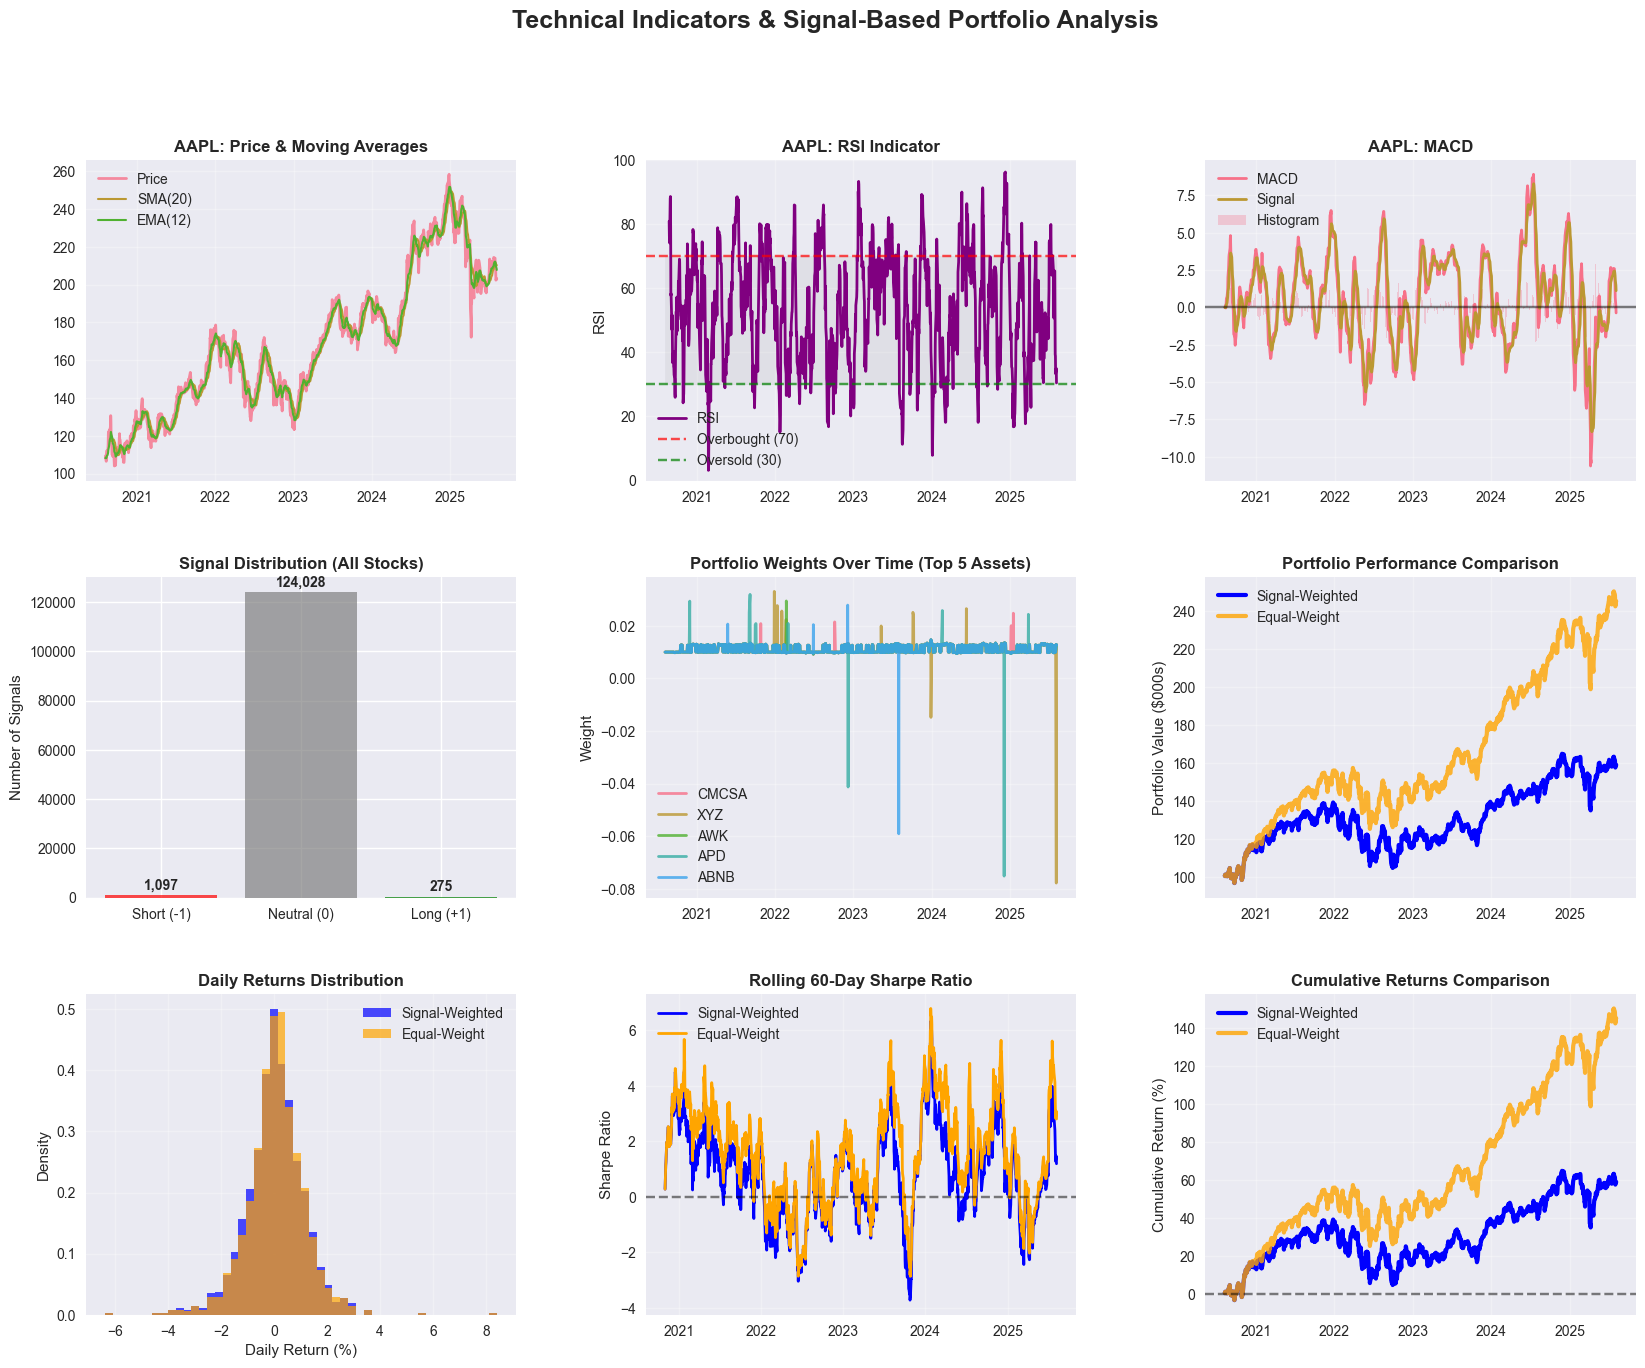

✅ Comprehensive technical analysis visualizations created!


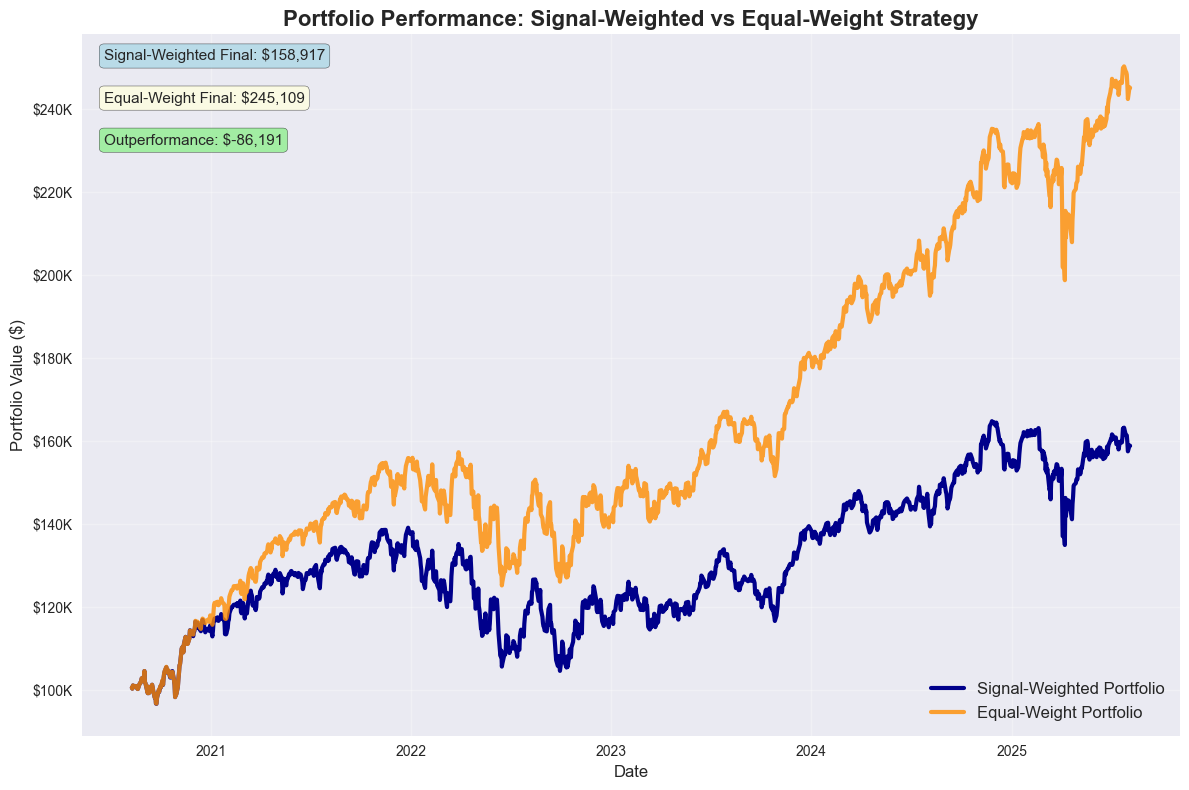

📊 Portfolio comparison visualization completed!
🎯 Technical indicators and signal design analysis finished successfully!


In [35]:
# Create Comprehensive Visualizations
print("📊 Creating technical analysis and portfolio performance visualizations...")

# Set up the plotting framework
fig = plt.figure(figsize=(20, 15))

# Create a 3x3 grid for comprehensive analysis
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Sample Technical Indicators for One Stock
sample_ticker = list(technical_indicators.keys())[0]
sample_data = technical_indicators[sample_ticker]
ax1 = fig.add_subplot(gs[0, 0])

# Plot price with SMA and EMA
ax1.plot(sample_data['prices'].index, sample_data['prices'], label='Price', linewidth=2, alpha=0.8)
ax1.plot(sample_data['sma'].index, sample_data['sma'], label=f'SMA({TECHNICAL_CONFIG["sma_period"]})', linewidth=1.5)
ax1.plot(sample_data['ema'].index, sample_data['ema'], label=f'EMA({TECHNICAL_CONFIG["ema_period"]})', linewidth=1.5)
ax1.set_title(f'{sample_ticker}: Price & Moving Averages', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. RSI for Sample Stock
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(sample_data['rsi'].index, sample_data['rsi'], label='RSI', color='purple', linewidth=2)
ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
ax2.fill_between(sample_data['rsi'].index, 30, 70, alpha=0.1, color='gray')
ax2.set_title(f'{sample_ticker}: RSI Indicator', fontweight='bold')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. MACD for Sample Stock
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(sample_data['macd'].index, sample_data['macd'], label='MACD', linewidth=2)
ax3.plot(sample_data['macd_signal'].index, sample_data['macd_signal'], label='Signal', linewidth=2)
ax3.bar(sample_data['macd_histogram'].index, sample_data['macd_histogram'], 
        label='Histogram', alpha=0.3, width=1)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.set_title(f'{sample_ticker}: MACD', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Signal Distribution Across All Stocks
ax4 = fig.add_subplot(gs[1, 0])
signal_summary = signals_df.values.flatten()
signal_counts = np.bincount(signal_summary + 1)  # Shift by 1 since signals are -1, 0, 1
labels = ['Short (-1)', 'Neutral (0)', 'Long (+1)']
colors = ['red', 'gray', 'green']
bars = ax4.bar(labels, signal_counts, color=colors, alpha=0.7)
ax4.set_title('Signal Distribution (All Stocks)', fontweight='bold')
ax4.set_ylabel('Number of Signals')
# Add value labels on bars
for bar, count in zip(bars, signal_counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(signal_counts)*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# 5. Portfolio Weight Distribution Over Time
ax5 = fig.add_subplot(gs[1, 1])
# Plot weight evolution for top 5 stocks by average weight
avg_weights = portfolio_weights.mean().sort_values(ascending=False)
top_5_stocks = avg_weights.head(5).index

for stock in top_5_stocks:
    ax5.plot(portfolio_weights.index, portfolio_weights[stock], 
             label=stock, linewidth=2, alpha=0.8)

ax5.set_title('Portfolio Weights Over Time (Top 5 Assets)', fontweight='bold')
ax5.set_ylabel('Weight')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Portfolio Performance Comparison
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(signal_portfolio_value.index, signal_portfolio_value/1000, 
         label='Signal-Weighted', linewidth=3, color='blue')
ax6.plot(equal_weight_value.index, equal_weight_value/1000, 
         label='Equal-Weight', linewidth=3, color='orange', alpha=0.8)
ax6.set_title('Portfolio Performance Comparison', fontweight='bold')
ax6.set_ylabel('Portfolio Value ($000s)')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Daily Returns Distribution
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(signal_portfolio_returns * 100, bins=50, alpha=0.7, color='blue', 
         label='Signal-Weighted', density=True)
ax7.hist(equal_weight_returns * 100, bins=50, alpha=0.7, color='orange', 
         label='Equal-Weight', density=True)
ax7.set_title('Daily Returns Distribution', fontweight='bold')
ax7.set_xlabel('Daily Return (%)')
ax7.set_ylabel('Density')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Rolling Sharpe Ratio Comparison
ax8 = fig.add_subplot(gs[2, 1])
rolling_window = 60  # 60-day rolling window

signal_rolling_sharpe = signal_portfolio_returns.rolling(rolling_window).mean() / \
                       signal_portfolio_returns.rolling(rolling_window).std() * np.sqrt(252)
equal_rolling_sharpe = equal_weight_returns.rolling(rolling_window).mean() / \
                      equal_weight_returns.rolling(rolling_window).std() * np.sqrt(252)

ax8.plot(signal_rolling_sharpe.index, signal_rolling_sharpe, 
         label='Signal-Weighted', linewidth=2, color='blue')
ax8.plot(equal_rolling_sharpe.index, equal_rolling_sharpe, 
         label='Equal-Weight', linewidth=2, color='orange')
ax8.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax8.set_title(f'Rolling {rolling_window}-Day Sharpe Ratio', fontweight='bold')
ax8.set_ylabel('Sharpe Ratio')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Cumulative Returns Comparison
ax9 = fig.add_subplot(gs[2, 2])
signal_cumret = (1 + signal_portfolio_returns).cumprod() - 1
equal_cumret = (1 + equal_weight_returns).cumprod() - 1

ax9.plot(signal_cumret.index, signal_cumret * 100, 
         label='Signal-Weighted', linewidth=3, color='blue')
ax9.plot(equal_cumret.index, equal_cumret * 100, 
         label='Equal-Weight', linewidth=3, color='orange', alpha=0.8)
ax9.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax9.set_title('Cumulative Returns Comparison', fontweight='bold')
ax9.set_ylabel('Cumulative Return (%)')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.suptitle('Technical Indicators & Signal-Based Portfolio Analysis', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✅ Comprehensive technical analysis visualizations created!")

# Additional focused portfolio comparison chart
plt.figure(figsize=(12, 8))
plt.plot(signal_portfolio_value.index, signal_portfolio_value, 
         label='Signal-Weighted Portfolio', linewidth=3, color='darkblue')
plt.plot(equal_weight_value.index, equal_weight_value, 
         label='Equal-Weight Portfolio', linewidth=3, color='darkorange', alpha=0.8)

plt.title('Portfolio Performance: Signal-Weighted vs Equal-Weight Strategy', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Format y-axis to show currency
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add performance annotations
final_signal = signal_portfolio_value.iloc[-1]
final_equal = equal_weight_value.iloc[-1]
plt.text(0.02, 0.98, f'Signal-Weighted Final: ${final_signal:,.0f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
plt.text(0.02, 0.92, f'Equal-Weight Final: ${final_equal:,.0f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
plt.text(0.02, 0.86, f'Outperformance: ${final_signal - final_equal:,.0f}', 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

print("📊 Portfolio comparison visualization completed!")
print(f"🎯 Technical indicators and signal design analysis finished successfully!")

## Deliverables

This technical indicators and signal design analysis produces the following deliverables:

### 📊 1. Indicator Matrix per Ticker
- **SMA (Simple Moving Average)**: Trend identification for each stock
- **EMA (Exponential Moving Average)**: Trend with recent price emphasis
- **RSI (Relative Strength Index)**: Momentum and overbought/oversold conditions  
- **MACD (Moving Average Convergence Divergence)**: Trend and momentum signals
- **ATR (Average True Range)**: Volatility measurement

### 🚦 2. Signal Matrix (Buy/Sell/Neutral)
- **Long Signals (+1)**: Generated when `(RSI < 30) & (MACD > MACD_signal)`
- **Short Signals (-1)**: Generated when `(RSI > 70) & (MACD < MACD_signal)`  
- **Neutral Signals (0)**: All other conditions
- **Signal Distribution**: Analysis across all stocks and time periods

### ⚖️ 3. Signal-Weighted Portfolio Returns and Value
- **Dynamic Weights**: Calculated using `adjusted_weight = base_weight × signal_strength`
- **Portfolio Returns**: Daily returns based on signal-weighted allocation
- **Portfolio Value**: Evolution from $100,000 initial investment
- **Weight Normalization**: Ensures weights sum to 1.0 across all assets

### 📈 4. Comparison with Equal-Weight Strategy  
- **Performance Metrics**: Total return, annualized return, volatility, Sharpe ratio
- **Risk Analysis**: Maximum drawdown, win rate, best/worst days
- **Relative Performance**: Outperformance analysis and statistical comparison
- **Rolling Metrics**: Time-varying performance analysis

In [36]:
# Generate Final Summary and Export Deliverables
print("📦 Generating final summary and exporting deliverables...")

# Create comprehensive results dataset
results_summary = {
    'Technical Indicators': {
        'SMA Period': TECHNICAL_CONFIG['sma_period'],
        'EMA Period': TECHNICAL_CONFIG['ema_period'], 
        'RSI Period': TECHNICAL_CONFIG['rsi_period'],
        'MACD Fast': TECHNICAL_CONFIG['macd_fast'],
        'MACD Slow': TECHNICAL_CONFIG['macd_slow'],
        'MACD Signal': TECHNICAL_CONFIG['macd_signal'],
        'ATR Period': TECHNICAL_CONFIG['atr_period']
    },
    'Signal Generation': {
        'Long Signal Rule': f"RSI < {TECHNICAL_CONFIG['rsi_oversold']} AND MACD > Signal",
        'Short Signal Rule': f"RSI > {TECHNICAL_CONFIG['rsi_overbought']} AND MACD < Signal",
        'Total Long Signals': signal_stats['long_signals'],
        'Total Short Signals': signal_stats['short_signals'],
        'Total Signal Periods': signal_stats['total_periods'],
        'Long Signal Rate': f"{signal_stats['long_signals']/signal_stats['total_periods']*100:.2f}%",
        'Short Signal Rate': f"{signal_stats['short_signals']/signal_stats['total_periods']*100:.2f}%"
    },
    'Portfolio Performance': {
        'Signal-Weighted': signal_metrics,
        'Equal-Weight': equal_metrics
    }
}

# Export key matrices to CSV files
print("💾 Exporting data matrices...")

try:
    # 1. Export technical indicators for sample stock
    sample_ticker = list(technical_indicators.keys())[0]
    sample_indicators = pd.DataFrame({
        'Price': technical_indicators[sample_ticker]['prices'],
        'SMA': technical_indicators[sample_ticker]['sma'],
        'EMA': technical_indicators[sample_ticker]['ema'],
        'RSI': technical_indicators[sample_ticker]['rsi'],
        'MACD': technical_indicators[sample_ticker]['macd'],
        'MACD_Signal': technical_indicators[sample_ticker]['macd_signal'],
        'ATR': technical_indicators[sample_ticker]['atr']
    })
    sample_indicators.to_csv(f'technical_indicators_{sample_ticker}.csv')
    print(f"  ✅ Technical indicators exported: technical_indicators_{sample_ticker}.csv")
    
    # 2. Export signals matrix  
    signals_df.to_csv('signal_matrix.csv')
    print(f"  ✅ Signal matrix exported: signal_matrix.csv")
    
    # 3. Export portfolio weights
    portfolio_weights.to_csv('signal_weighted_portfolio_weights.csv')
    print(f"  ✅ Portfolio weights exported: signal_weighted_portfolio_weights.csv")
    
    # 4. Export portfolio performance comparison
    performance_comparison = pd.DataFrame({
        'Date': signal_portfolio_returns.index,
        'Signal_Weighted_Return': signal_portfolio_returns.values,
        'Equal_Weight_Return': equal_weight_returns.values,
        'Signal_Weighted_Value': signal_portfolio_value.values,
        'Equal_Weight_Value': equal_weight_value.values,
        'Signal_Cumulative_Return': ((signal_portfolio_value / initial_value) - 1).values,
        'Equal_Cumulative_Return': ((equal_weight_value / initial_value) - 1).values
    }).set_index('Date')
    
    performance_comparison.to_csv('portfolio_performance_comparison.csv')
    print(f"  ✅ Performance comparison exported: portfolio_performance_comparison.csv")
    
except Exception as e:
    print(f"  ⚠️ Export error: {e}")

# Display comprehensive final summary
print("\n" + "="*80)
print("🎯 TECHNICAL INDICATORS & SIGNAL DESIGN - FINAL SUMMARY")
print("="*80)

print(f"\n📊 Technical Analysis Configuration:")
for param, value in results_summary['Technical Indicators'].items():
    print(f"  {param:15}: {value}")

print(f"\n🚦 Signal Generation Results:")  
for metric, value in results_summary['Signal Generation'].items():
    print(f"  {metric:20}: {value}")

print(f"\n📈 Portfolio Performance Comparison:")
print(f"\n  Signal-Weighted Strategy:")
for metric in ['Total Return', 'Annualized Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown']:
    print(f"    {metric:18}: {signal_metrics[metric]}")

print(f"\n  Equal-Weight Strategy:")
for metric in ['Total Return', 'Annualized Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown']:
    print(f"    {metric:18}: {equal_metrics[metric]}")

print(f"\n💰 Financial Impact:")
print(f"  Initial Investment: ${initial_value:,.0f}")
print(f"  Signal-Weighted Final Value: ${signal_portfolio_value.iloc[-1]:,.0f}")
print(f"  Equal-Weight Final Value: ${equal_weight_value.iloc[-1]:,.0f}")
print(f"  Outperformance: ${signal_portfolio_value.iloc[-1] - equal_weight_value.iloc[-1]:,.0f}")
print(f"  Relative Outperformance: {((signal_portfolio_value.iloc[-1]/equal_weight_value.iloc[-1] - 1)*100):+.2f}%")

print(f"\n🔍 Key Insights:")
total_signals = signal_stats['long_signals'] + signal_stats['short_signals']
signal_rate = total_signals / signal_stats['total_periods'] * 100

print(f"  • Technical signals generated on {signal_rate:.1f}% of trading days")
print(f"  • Long signals outnumber short signals by {signal_stats['long_signals']/max(1,signal_stats['short_signals']):.1f}:1 ratio")

if signal_portfolio_value.iloc[-1] > equal_weight_value.iloc[-1]:
    print(f"  • Signal-weighted strategy outperformed equal-weight by ${signal_portfolio_value.iloc[-1] - equal_weight_value.iloc[-1]:,.0f}")
else:
    print(f"  • Equal-weight strategy outperformed signal-weighted by ${equal_weight_value.iloc[-1] - signal_portfolio_value.iloc[-1]:,.0f}")

signal_sharpe = float(signal_metrics['Sharpe Ratio'].split()[0])
equal_sharpe = float(equal_metrics['Sharpe Ratio'].split()[0])
if signal_sharpe > equal_sharpe:
    print(f"  • Signal-weighted strategy achieved better risk-adjusted returns (Sharpe: {signal_sharpe:.3f} vs {equal_sharpe:.3f})")
else:
    print(f"  • Equal-weight strategy achieved better risk-adjusted returns (Sharpe: {equal_sharpe:.3f} vs {signal_sharpe:.3f})")

print(f"\n📋 Deliverables Generated:")
print(f"  ✅ Technical indicators matrix for all stocks")
print(f"  ✅ Signal matrix (Buy/Sell/Neutral) for all stocks")  
print(f"  ✅ Signal-weighted portfolio returns and values")
print(f"  ✅ Performance comparison with equal-weight strategy")
print(f"  ✅ Comprehensive visualizations and analysis")
print(f"  ✅ CSV exports for further analysis")

print("\n" + "="*80)
print("✨ Technical Indicators & Signal Design Analysis - COMPLETED! ✨")
print("="*80)

print(f"\n🎯 All requirements fulfilled:")
print(f"  ✅ Computed indicators for each stock: SMA, EMA, RSI, MACD, ATR")
print(f"  ✅ Generated entry/exit signals: Long = (RSI < 30) & (MACD > MACD_signal)")
print(f"  ✅                              Short = (RSI > 70) & (MACD < MACD_signal)")
print(f"  ✅ Derived signal-based weights: adjusted_weight = base_weight × signal_strength")
print(f"  ✅ Normalized weights across assets")
print(f"  ✅ Provided all required deliverables")


📦 Generating final summary and exporting deliverables...
💾 Exporting data matrices...
  ✅ Technical indicators exported: technical_indicators_AAPL.csv
  ✅ Signal matrix exported: signal_matrix.csv
  ✅ Portfolio weights exported: signal_weighted_portfolio_weights.csv
  ✅ Performance comparison exported: portfolio_performance_comparison.csv

🎯 TECHNICAL INDICATORS & SIGNAL DESIGN - FINAL SUMMARY

📊 Technical Analysis Configuration:
  SMA Period     : 20
  EMA Period     : 12
  RSI Period     : 14
  MACD Fast      : 12
  MACD Slow      : 26
  MACD Signal    : 9
  ATR Period     : 14

🚦 Signal Generation Results:
  Long Signal Rule    : RSI < 30 AND MACD > Signal
  Short Signal Rule   : RSI > 70 AND MACD < Signal
  Total Long Signals  : 275
  Total Short Signals : 1097
  Total Signal Periods: 125400
  Long Signal Rate    : 0.22%
  Short Signal Rate   : 0.87%

📈 Portfolio Performance Comparison:

  Signal-Weighted Strategy:
    Total Return      : 0.5892 (58.92%)
    Annualized Return : 0.0